In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='5'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC='mean_temp'
SAMPLE_SIZE=5000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV2,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV2,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v2', f'profiles-v2-jsons')
ORIGINAL_PROFILE_LIST_JSON = os.path.join(DATASET_DIR, f'profiles-v2', f'profile_list_v2.json')
LABEL = f'profiles_v2_experiment_{EXPERIMENT_NUM}'
BINNED_PROFILE_LIST = os.path.join(DATASET_DIR, 'profiles-v2', 'profile_list_v2_binned.json')

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v2_experiment_5_20250401_0537


In [3]:
# * * * * * * * * * * * * * * * *
# Create Subset by Metric
# * * * * * * * * * * * * * * * *
SUBSET_PROFILE_LIST = os.path.join(model_dir, f'profile_list_v2_{TARGET_METRIC}_{SAMPLE_SIZE}.json')
CreateProfileSubset(BINNED_PROFILE_LIST, SUBSET_PROFILE_LIST, TARGET_METRIC, SAMPLE_SIZE)

In [4]:
# * * * * * * * * * * * * * * * *
# Load Profile List
# * * * * * * * * * * * * * * * *
profile_list = LoadProfileList(SUBSET_PROFILE_LIST)

In [5]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 142568/142568 [00:57<00:00, 2480.09it/s]

Saved 142568 profiles to /workspace/outputs/profiles_v2_experiment_5_20250401_0537/20250401-dataset.csv


In [6]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV2(csv_path, DEVICE)

Loading Profiles: 142568it [00:07, 18524.17it/s]


Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250401_0537/density_plot.png


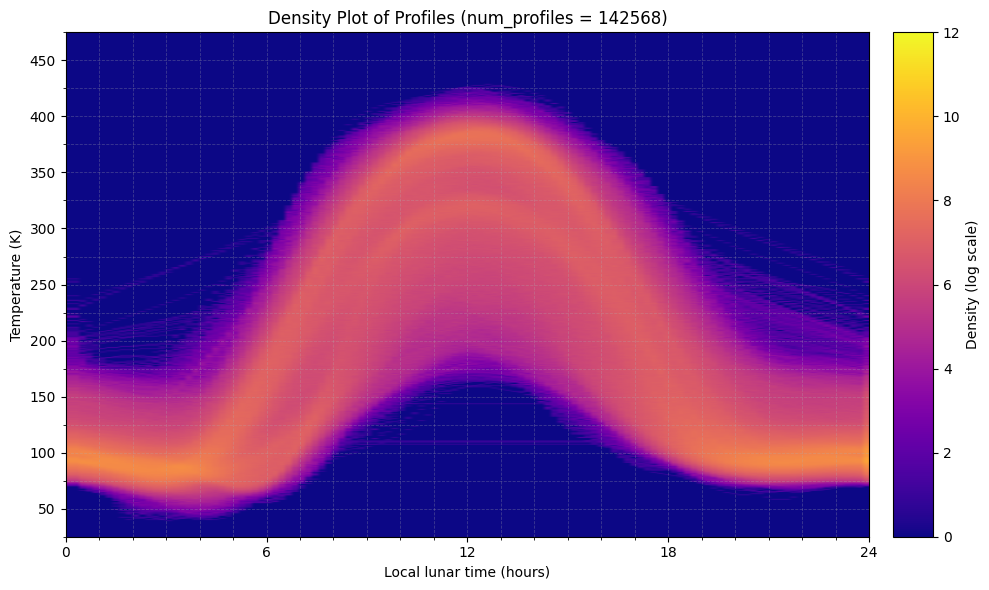

In [7]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [8]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250401_0537/histogram_max_temp.png


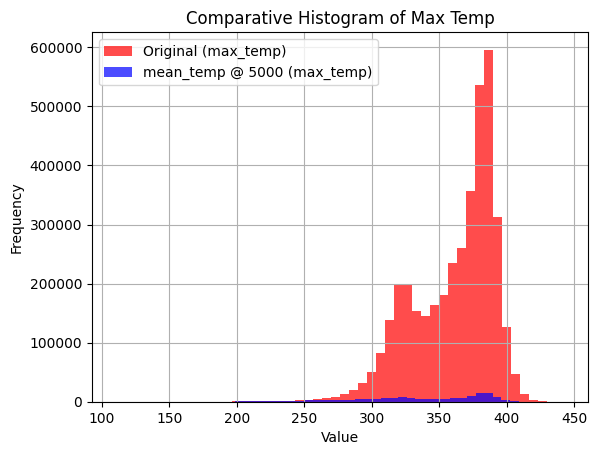

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250401_0537/histogram_min_temp.png


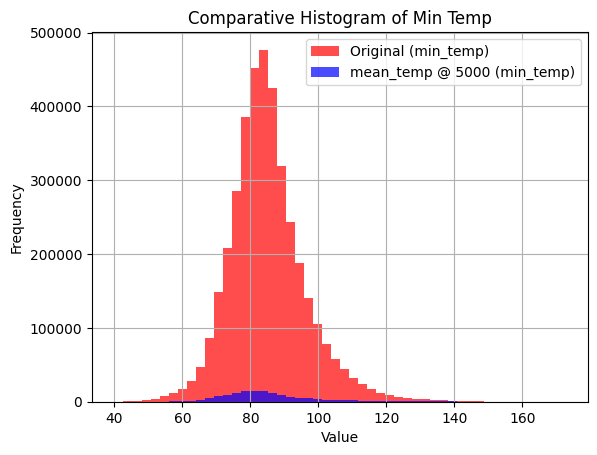

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250401_0537/histogram_mean_temp.png


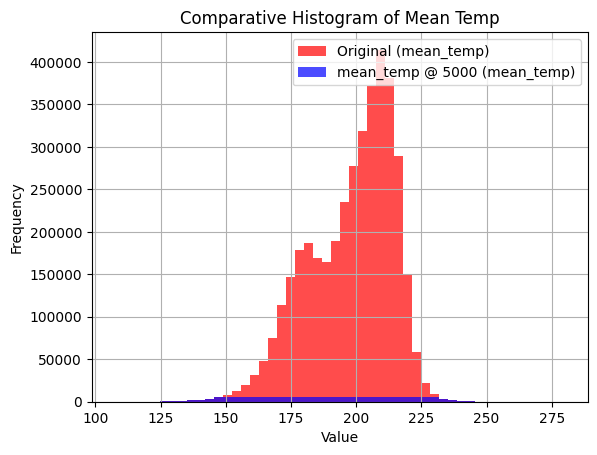

Saved figure to /workspace/outputs/profiles_v2_experiment_5_20250401_0537/histogram_std_temp.png


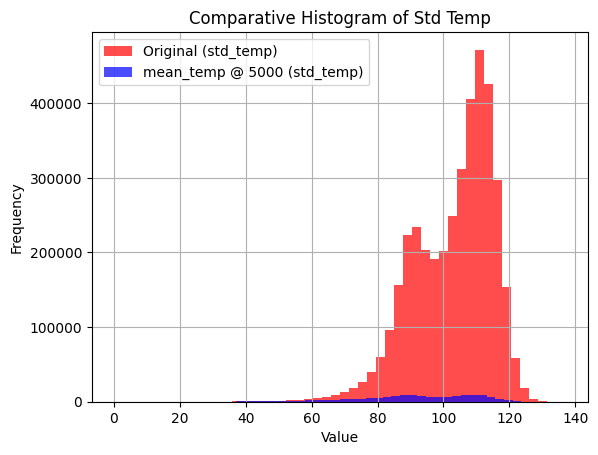

In [9]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV2(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV2(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [10]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 186.9380
STD: 97.8951
Min Temp: 40.0240
Max Temp: 427.9520
Datasets:
Training Data: 99797
Validation Data: 28513
Test Data: 14258


In [11]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [12]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 499/499 [00:15<00:00, 31.75it/s, best_loss=0.5446]


[Training] Epoch 1/100, L1 Loss: 0.5980, L2 Loss: 0.6018, KL Loss: 0.4531, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 143/143 [00:01<00:00, 108.15it/s]


[Validation] Epoch 1/100, Val L1 Loss: 0.5164, Val L2 Loss: 0.4920, Val KL Loss: 0.5141
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250401_0537'


[Training] Epoch 2/100: 100%|██████████| 499/499 [00:15<00:00, 31.45it/s, best_loss=0.5381]


[Training] Epoch 2/100, L1 Loss: 0.5557, L2 Loss: 0.5371, KL Loss: 0.5243, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 143/143 [00:01<00:00, 120.93it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5090, Val L2 Loss: 0.4854, Val KL Loss: 0.5308
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250401_0537'


[Training] Epoch 3/100: 100%|██████████| 499/499 [00:16<00:00, 30.98it/s, best_loss=0.5459]


[Training] Epoch 3/100, L1 Loss: 0.5543, L2 Loss: 0.5350, KL Loss: 0.5274, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 143/143 [00:01<00:00, 116.85it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.4855, Val KL Loss: 0.5231


[Training] Epoch 4/100: 100%|██████████| 499/499 [00:15<00:00, 32.87it/s, best_loss=0.5506]


[Training] Epoch 4/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 143/143 [00:01<00:00, 113.27it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.4850, Val KL Loss: 0.5290
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250401_0537'


[Training] Epoch 5/100: 100%|██████████| 499/499 [00:15<00:00, 31.80it/s, best_loss=0.5368]


[Training] Epoch 5/100, L1 Loss: 0.5537, L2 Loss: 0.5345, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 143/143 [00:01<00:00, 109.26it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5085, Val L2 Loss: 0.4851, Val KL Loss: 0.5285


[Training] Epoch 6/100: 100%|██████████| 499/499 [00:15<00:00, 31.73it/s, best_loss=0.5246]


[Training] Epoch 6/100, L1 Loss: 0.5534, L2 Loss: 0.5341, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 143/143 [00:01<00:00, 113.43it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5106, Val L2 Loss: 0.4867, Val KL Loss: 0.5223


[Training] Epoch 7/100: 100%|██████████| 499/499 [00:16<00:00, 30.81it/s, best_loss=0.5407]


[Training] Epoch 7/100, L1 Loss: 0.5539, L2 Loss: 0.5349, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 143/143 [00:01<00:00, 100.74it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5083, Val L2 Loss: 0.4847, Val KL Loss: 0.5315
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250401_0537'


[Training] Epoch 8/100: 100%|██████████| 499/499 [00:15<00:00, 32.01it/s, best_loss=0.5413]


[Training] Epoch 8/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 143/143 [00:01<00:00, 111.85it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5127, Val L2 Loss: 0.4884, Val KL Loss: 0.5157


[Training] Epoch 9/100: 100%|██████████| 499/499 [00:16<00:00, 30.86it/s, best_loss=0.5368]


[Training] Epoch 9/100, L1 Loss: 0.5542, L2 Loss: 0.5351, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 143/143 [00:01<00:00, 103.12it/s]


[Validation] Epoch 9/100, Val L1 Loss: 0.5106, Val L2 Loss: 0.4868, Val KL Loss: 0.5225


[Training] Epoch 10/100: 100%|██████████| 499/499 [00:15<00:00, 31.25it/s, best_loss=0.5302]


[Training] Epoch 10/100, L1 Loss: 0.5544, L2 Loss: 0.5356, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 143/143 [00:01<00:00, 104.04it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5066, Val L2 Loss: 0.4834, Val KL Loss: 0.5358
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250401_0537'


[Training] Epoch 11/100: 100%|██████████| 499/499 [00:16<00:00, 30.98it/s, best_loss=0.5154]


[Training] Epoch 11/100, L1 Loss: 0.5536, L2 Loss: 0.5344, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 143/143 [00:01<00:00, 104.82it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5090, Val L2 Loss: 0.4855, Val KL Loss: 0.5318


[Training] Epoch 12/100: 100%|██████████| 499/499 [00:15<00:00, 32.75it/s, best_loss=0.5210]


[Training] Epoch 12/100, L1 Loss: 0.5539, L2 Loss: 0.5349, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 143/143 [00:01<00:00, 110.06it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.4860, Val KL Loss: 0.5235


[Training] Epoch 13/100: 100%|██████████| 499/499 [00:15<00:00, 31.40it/s, best_loss=0.5532]


[Training] Epoch 13/100, L1 Loss: 0.5540, L2 Loss: 0.5351, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 143/143 [00:01<00:00, 107.93it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5092, Val L2 Loss: 0.4854, Val KL Loss: 0.5262


[Training] Epoch 14/100: 100%|██████████| 499/499 [00:15<00:00, 32.16it/s, best_loss=0.5307]


[Training] Epoch 14/100, L1 Loss: 0.5539, L2 Loss: 0.5348, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 143/143 [00:01<00:00, 106.54it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5093, Val L2 Loss: 0.4856, Val KL Loss: 0.5236


[Training] Epoch 15/100: 100%|██████████| 499/499 [00:15<00:00, 31.34it/s, best_loss=0.5294]


[Training] Epoch 15/100, L1 Loss: 0.5538, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 143/143 [00:01<00:00, 109.59it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5081, Val L2 Loss: 0.4847, Val KL Loss: 0.5292


[Training] Epoch 16/100: 100%|██████████| 499/499 [00:15<00:00, 31.92it/s, best_loss=0.5394]


[Training] Epoch 16/100, L1 Loss: 0.5540, L2 Loss: 0.5351, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 143/143 [00:01<00:00, 109.43it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5141, Val L2 Loss: 0.4896, Val KL Loss: 0.5137


[Training] Epoch 17/100: 100%|██████████| 499/499 [00:15<00:00, 31.60it/s, best_loss=0.5422]


[Training] Epoch 17/100, L1 Loss: 0.5541, L2 Loss: 0.5352, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 143/143 [00:01<00:00, 114.46it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.4862, Val KL Loss: 0.5246


[Training] Epoch 18/100: 100%|██████████| 499/499 [00:16<00:00, 31.18it/s, best_loss=0.5390]


[Training] Epoch 18/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 143/143 [00:01<00:00, 105.75it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5112, Val L2 Loss: 0.4873, Val KL Loss: 0.5225


[Training] Epoch 19/100: 100%|██████████| 499/499 [00:16<00:00, 31.11it/s, best_loss=0.5434]


[Training] Epoch 19/100, L1 Loss: 0.5542, L2 Loss: 0.5351, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 143/143 [00:01<00:00, 109.81it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5084, Val L2 Loss: 0.4850, Val KL Loss: 0.5292


[Training] Epoch 20/100: 100%|██████████| 499/499 [00:15<00:00, 31.43it/s, best_loss=0.5327]


[Training] Epoch 20/100, L1 Loss: 0.5539, L2 Loss: 0.5346, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 143/143 [00:01<00:00, 110.89it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5082, Val L2 Loss: 0.4850, Val KL Loss: 0.5296


[Training] Epoch 21/100: 100%|██████████| 499/499 [00:16<00:00, 30.41it/s, best_loss=0.5492]


[Training] Epoch 21/100, L1 Loss: 0.5543, L2 Loss: 0.5354, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 143/143 [00:01<00:00, 103.83it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5090, Val L2 Loss: 0.4854, Val KL Loss: 0.5263


[Training] Epoch 22/100: 100%|██████████| 499/499 [00:15<00:00, 31.74it/s, best_loss=0.5314]


[Training] Epoch 22/100, L1 Loss: 0.5538, L2 Loss: 0.5347, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 143/143 [00:01<00:00, 108.90it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5085, Val L2 Loss: 0.4849, Val KL Loss: 0.5283


[Training] Epoch 23/100: 100%|██████████| 499/499 [00:15<00:00, 31.65it/s, best_loss=0.5545]


[Training] Epoch 23/100, L1 Loss: 0.5542, L2 Loss: 0.5354, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 143/143 [00:01<00:00, 87.38it/s] 


[Validation] Epoch 23/100, Val L1 Loss: 0.5082, Val L2 Loss: 0.4850, Val KL Loss: 0.5294


[Training] Epoch 24/100: 100%|██████████| 499/499 [00:15<00:00, 31.62it/s, best_loss=0.5525]


[Training] Epoch 24/100, L1 Loss: 0.5538, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 143/143 [00:01<00:00, 105.39it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5089, Val L2 Loss: 0.4854, Val KL Loss: 0.5269


[Training] Epoch 25/100: 100%|██████████| 499/499 [00:15<00:00, 32.23it/s, best_loss=0.5342]


[Training] Epoch 25/100, L1 Loss: 0.5543, L2 Loss: 0.5353, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 143/143 [00:01<00:00, 92.49it/s] 


[Validation] Epoch 25/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.4861, Val KL Loss: 0.5251


[Training] Epoch 26/100: 100%|██████████| 499/499 [00:15<00:00, 31.93it/s, best_loss=0.5571]


[Training] Epoch 26/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 143/143 [00:01<00:00, 105.85it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5073, Val L2 Loss: 0.4841, Val KL Loss: 0.5284


[Training] Epoch 27/100: 100%|██████████| 499/499 [00:15<00:00, 32.19it/s, best_loss=0.5311]


[Training] Epoch 27/100, L1 Loss: 0.5536, L2 Loss: 0.5343, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 143/143 [00:01<00:00, 88.88it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5076, Val L2 Loss: 0.4842, Val KL Loss: 0.5329


[Training] Epoch 28/100: 100%|██████████| 499/499 [00:15<00:00, 31.32it/s, best_loss=0.5484]


[Training] Epoch 28/100, L1 Loss: 0.5536, L2 Loss: 0.5345, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 143/143 [00:01<00:00, 106.39it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5112, Val L2 Loss: 0.4872, Val KL Loss: 0.5197


[Training] Epoch 29/100: 100%|██████████| 499/499 [00:15<00:00, 31.72it/s, best_loss=0.5260]


[Training] Epoch 29/100, L1 Loss: 0.5541, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 143/143 [00:01<00:00, 92.01it/s] 


[Validation] Epoch 29/100, Val L1 Loss: 0.5109, Val L2 Loss: 0.4870, Val KL Loss: 0.5196


[Training] Epoch 30/100: 100%|██████████| 499/499 [00:15<00:00, 31.66it/s, best_loss=0.5490]


[Training] Epoch 30/100, L1 Loss: 0.5543, L2 Loss: 0.5353, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 143/143 [00:01<00:00, 111.95it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.4879, Val KL Loss: 0.5151


[Training] Epoch 31/100: 100%|██████████| 499/499 [00:15<00:00, 32.46it/s, best_loss=0.5312]


[Training] Epoch 31/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 143/143 [00:01<00:00, 85.29it/s] 


[Validation] Epoch 31/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.4861, Val KL Loss: 0.5247


[Training] Epoch 32/100: 100%|██████████| 499/499 [00:15<00:00, 31.65it/s, best_loss=0.5045]


[Training] Epoch 32/100, L1 Loss: 0.5540, L2 Loss: 0.5352, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 143/143 [00:01<00:00, 108.97it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.4861, Val KL Loss: 0.5234


[Training] Epoch 33/100: 100%|██████████| 499/499 [00:15<00:00, 31.62it/s, best_loss=0.5506]


[Training] Epoch 33/100, L1 Loss: 0.5543, L2 Loss: 0.5353, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 143/143 [00:01<00:00, 108.90it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5105, Val L2 Loss: 0.4866, Val KL Loss: 0.5239


[Training] Epoch 34/100: 100%|██████████| 499/499 [00:15<00:00, 31.26it/s, best_loss=0.5434]


[Training] Epoch 34/100, L1 Loss: 0.5538, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 143/143 [00:01<00:00, 119.27it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5097, Val L2 Loss: 0.4861, Val KL Loss: 0.5207


[Training] Epoch 35/100: 100%|██████████| 499/499 [00:15<00:00, 32.09it/s, best_loss=0.5183]


[Training] Epoch 35/100, L1 Loss: 0.5541, L2 Loss: 0.5352, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 143/143 [00:01<00:00, 107.51it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5131, Val L2 Loss: 0.4888, Val KL Loss: 0.5146


[Training] Epoch 36/100: 100%|██████████| 499/499 [00:16<00:00, 31.11it/s, best_loss=0.5166]


[Training] Epoch 36/100, L1 Loss: 0.5539, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 143/143 [00:01<00:00, 108.26it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5110, Val L2 Loss: 0.4870, Val KL Loss: 0.5208


[Training] Epoch 37/100: 100%|██████████| 499/499 [00:15<00:00, 33.02it/s, best_loss=0.5253]


[Training] Epoch 37/100, L1 Loss: 0.5539, L2 Loss: 0.5349, KL Loss: 0.5269, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 143/143 [00:01<00:00, 115.71it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5103, Val L2 Loss: 0.4864, Val KL Loss: 0.5225


[Training] Epoch 38/100: 100%|██████████| 499/499 [00:15<00:00, 31.51it/s, best_loss=0.5563]


[Training] Epoch 38/100, L1 Loss: 0.5539, L2 Loss: 0.5350, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 143/143 [00:01<00:00, 105.01it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5082, Val L2 Loss: 0.4849, Val KL Loss: 0.5271


[Training] Epoch 39/100: 100%|██████████| 499/499 [00:15<00:00, 31.94it/s, best_loss=0.5411]


[Training] Epoch 39/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 143/143 [00:01<00:00, 107.35it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5115, Val L2 Loss: 0.4875, Val KL Loss: 0.5149


[Training] Epoch 40/100: 100%|██████████| 499/499 [00:16<00:00, 31.05it/s, best_loss=0.5511]


[Training] Epoch 40/100, L1 Loss: 0.5539, L2 Loss: 0.5347, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 143/143 [00:01<00:00, 109.54it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5105, Val L2 Loss: 0.4866, Val KL Loss: 0.5220


[Training] Epoch 41/100: 100%|██████████| 499/499 [00:15<00:00, 32.10it/s, best_loss=0.5399]


[Training] Epoch 41/100, L1 Loss: 0.5541, L2 Loss: 0.5349, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 143/143 [00:01<00:00, 106.63it/s]


[Validation] Epoch 41/100, Val L1 Loss: 0.5098, Val L2 Loss: 0.4861, Val KL Loss: 0.5262


[Training] Epoch 42/100: 100%|██████████| 499/499 [00:15<00:00, 31.87it/s, best_loss=0.5542]


[Training] Epoch 42/100, L1 Loss: 0.5538, L2 Loss: 0.5348, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 143/143 [00:01<00:00, 111.63it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5083, Val L2 Loss: 0.4850, Val KL Loss: 0.5309


[Training] Epoch 43/100: 100%|██████████| 499/499 [00:15<00:00, 32.19it/s, best_loss=0.5485]


[Training] Epoch 43/100, L1 Loss: 0.5539, L2 Loss: 0.5351, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 143/143 [00:01<00:00, 120.15it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5114, Val L2 Loss: 0.4874, Val KL Loss: 0.5199


[Training] Epoch 44/100: 100%|██████████| 499/499 [00:15<00:00, 31.50it/s, best_loss=0.5434]


[Training] Epoch 44/100, L1 Loss: 0.5543, L2 Loss: 0.5355, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 143/143 [00:01<00:00, 110.17it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5106, Val L2 Loss: 0.4869, Val KL Loss: 0.5212


[Training] Epoch 45/100: 100%|██████████| 499/499 [00:14<00:00, 33.70it/s, best_loss=0.5563]


[Training] Epoch 45/100, L1 Loss: 0.5539, L2 Loss: 0.5345, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 143/143 [00:01<00:00, 109.36it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5080, Val L2 Loss: 0.4848, Val KL Loss: 0.5267


[Training] Epoch 46/100: 100%|██████████| 499/499 [00:16<00:00, 30.79it/s, best_loss=0.5433]


[Training] Epoch 46/100, L1 Loss: 0.5539, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 143/143 [00:01<00:00, 104.98it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5126, Val L2 Loss: 0.4882, Val KL Loss: 0.5189


[Training] Epoch 47/100: 100%|██████████| 499/499 [00:15<00:00, 31.77it/s, best_loss=0.5495]


[Training] Epoch 47/100, L1 Loss: 0.5549, L2 Loss: 0.5362, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 143/143 [00:01<00:00, 107.00it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.4880, Val KL Loss: 0.5180


[Training] Epoch 48/100: 100%|██████████| 499/499 [00:15<00:00, 31.65it/s, best_loss=0.5350]


[Training] Epoch 48/100, L1 Loss: 0.5538, L2 Loss: 0.5348, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 143/143 [00:01<00:00, 110.53it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5119, Val L2 Loss: 0.4878, Val KL Loss: 0.5163


[Training] Epoch 49/100: 100%|██████████| 499/499 [00:15<00:00, 32.03it/s, best_loss=0.5294]


[Training] Epoch 49/100, L1 Loss: 0.5539, L2 Loss: 0.5346, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 143/143 [00:01<00:00, 118.80it/s]


[Validation] Epoch 49/100, Val L1 Loss: 0.5105, Val L2 Loss: 0.4866, Val KL Loss: 0.5209


[Training] Epoch 50/100: 100%|██████████| 499/499 [00:15<00:00, 31.64it/s, best_loss=0.5421]


[Training] Epoch 50/100, L1 Loss: 0.5541, L2 Loss: 0.5351, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 143/143 [00:01<00:00, 107.01it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5108, Val L2 Loss: 0.4870, Val KL Loss: 0.5183


[Training] Epoch 51/100: 100%|██████████| 499/499 [00:15<00:00, 31.80it/s, best_loss=0.5445]


[Training] Epoch 51/100, L1 Loss: 0.5539, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 143/143 [00:01<00:00, 113.67it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5109, Val L2 Loss: 0.4869, Val KL Loss: 0.5200


[Training] Epoch 52/100: 100%|██████████| 499/499 [00:16<00:00, 31.10it/s, best_loss=0.5414]


[Training] Epoch 52/100, L1 Loss: 0.5542, L2 Loss: 0.5351, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 143/143 [00:01<00:00, 110.00it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5127, Val L2 Loss: 0.4884, Val KL Loss: 0.5163


[Training] Epoch 53/100: 100%|██████████| 499/499 [00:15<00:00, 31.94it/s, best_loss=0.5547]


[Training] Epoch 53/100, L1 Loss: 0.5539, L2 Loss: 0.5348, KL Loss: 0.5269, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 143/143 [00:01<00:00, 112.66it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5105, Val L2 Loss: 0.4868, Val KL Loss: 0.5224


[Training] Epoch 54/100: 100%|██████████| 499/499 [00:15<00:00, 31.50it/s, best_loss=0.5393]


[Training] Epoch 54/100, L1 Loss: 0.5542, L2 Loss: 0.5353, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 143/143 [00:01<00:00, 101.56it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5100, Val L2 Loss: 0.4861, Val KL Loss: 0.5219


[Training] Epoch 55/100: 100%|██████████| 499/499 [00:15<00:00, 32.85it/s, best_loss=0.5500]


[Training] Epoch 55/100, L1 Loss: 0.5541, L2 Loss: 0.5351, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 143/143 [00:01<00:00, 112.80it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5079, Val L2 Loss: 0.4848, Val KL Loss: 0.5306


[Training] Epoch 56/100: 100%|██████████| 499/499 [00:15<00:00, 31.58it/s, best_loss=0.5372]


[Training] Epoch 56/100, L1 Loss: 0.5537, L2 Loss: 0.5346, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 143/143 [00:01<00:00, 113.21it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5075, Val L2 Loss: 0.4841, Val KL Loss: 0.5290


[Training] Epoch 57/100: 100%|██████████| 499/499 [00:15<00:00, 32.20it/s, best_loss=0.5374]


[Training] Epoch 57/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 143/143 [00:01<00:00, 110.00it/s]


[Validation] Epoch 57/100, Val L1 Loss: 0.5073, Val L2 Loss: 0.4840, Val KL Loss: 0.5344


[Training] Epoch 58/100: 100%|██████████| 499/499 [00:16<00:00, 30.33it/s, best_loss=0.5582]


[Training] Epoch 58/100, L1 Loss: 0.5540, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 143/143 [00:01<00:00, 109.37it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5096, Val L2 Loss: 0.4859, Val KL Loss: 0.5232


[Training] Epoch 59/100: 100%|██████████| 499/499 [00:15<00:00, 32.22it/s, best_loss=0.5394]


[Training] Epoch 59/100, L1 Loss: 0.5544, L2 Loss: 0.5356, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 143/143 [00:01<00:00, 110.71it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5101, Val L2 Loss: 0.4864, Val KL Loss: 0.5227


[Training] Epoch 60/100: 100%|██████████| 499/499 [00:15<00:00, 31.66it/s, best_loss=0.5395]


[Training] Epoch 60/100, L1 Loss: 0.5534, L2 Loss: 0.5344, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 143/143 [00:01<00:00, 110.40it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.4861, Val KL Loss: 0.5239


[Training] Epoch 61/100: 100%|██████████| 499/499 [00:15<00:00, 31.47it/s, best_loss=0.5435]


[Training] Epoch 61/100, L1 Loss: 0.5543, L2 Loss: 0.5355, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 143/143 [00:01<00:00, 108.22it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5101, Val L2 Loss: 0.4863, Val KL Loss: 0.5214


[Training] Epoch 62/100: 100%|██████████| 499/499 [00:16<00:00, 30.75it/s, best_loss=0.5476]


[Training] Epoch 62/100, L1 Loss: 0.5540, L2 Loss: 0.5348, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 143/143 [00:01<00:00, 113.66it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5075, Val L2 Loss: 0.4844, Val KL Loss: 0.5327


[Training] Epoch 63/100: 100%|██████████| 499/499 [00:15<00:00, 32.28it/s, best_loss=0.5518]


[Training] Epoch 63/100, L1 Loss: 0.5535, L2 Loss: 0.5345, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 143/143 [00:01<00:00, 113.51it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5110, Val L2 Loss: 0.4871, Val KL Loss: 0.5167


[Training] Epoch 64/100: 100%|██████████| 499/499 [00:15<00:00, 31.50it/s, best_loss=0.5436]


[Training] Epoch 64/100, L1 Loss: 0.5540, L2 Loss: 0.5349, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 143/143 [00:01<00:00, 109.44it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5086, Val L2 Loss: 0.4850, Val KL Loss: 0.5261


[Training] Epoch 65/100: 100%|██████████| 499/499 [00:15<00:00, 31.96it/s, best_loss=0.5392]


[Training] Epoch 65/100, L1 Loss: 0.5539, L2 Loss: 0.5348, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 143/143 [00:01<00:00, 113.40it/s]


[Validation] Epoch 65/100, Val L1 Loss: 0.5065, Val L2 Loss: 0.4836, Val KL Loss: 0.5327
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250401_0537'


[Training] Epoch 66/100: 100%|██████████| 499/499 [00:15<00:00, 31.47it/s, best_loss=0.5003]


[Training] Epoch 66/100, L1 Loss: 0.5536, L2 Loss: 0.5346, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 143/143 [00:01<00:00, 108.83it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5087, Val L2 Loss: 0.4852, Val KL Loss: 0.5252


[Training] Epoch 67/100: 100%|██████████| 499/499 [00:15<00:00, 33.06it/s, best_loss=0.5321]


[Training] Epoch 67/100, L1 Loss: 0.5542, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 143/143 [00:01<00:00, 105.35it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5067, Val L2 Loss: 0.4836, Val KL Loss: 0.5366


[Training] Epoch 68/100: 100%|██████████| 499/499 [00:15<00:00, 31.82it/s, best_loss=0.5229]


[Training] Epoch 68/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 143/143 [00:01<00:00, 112.70it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5090, Val L2 Loss: 0.4856, Val KL Loss: 0.5256


[Training] Epoch 69/100: 100%|██████████| 499/499 [00:15<00:00, 31.78it/s, best_loss=0.5484]


[Training] Epoch 69/100, L1 Loss: 0.5540, L2 Loss: 0.5352, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 143/143 [00:01<00:00, 120.53it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5099, Val L2 Loss: 0.4863, Val KL Loss: 0.5210


[Training] Epoch 70/100: 100%|██████████| 499/499 [00:15<00:00, 31.32it/s, best_loss=0.5462]


[Training] Epoch 70/100, L1 Loss: 0.5540, L2 Loss: 0.5349, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 143/143 [00:01<00:00, 108.25it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5101, Val L2 Loss: 0.4863, Val KL Loss: 0.5221


[Training] Epoch 71/100: 100%|██████████| 499/499 [00:15<00:00, 31.68it/s, best_loss=0.5548]


[Training] Epoch 71/100, L1 Loss: 0.5541, L2 Loss: 0.5347, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 143/143 [00:01<00:00, 118.34it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5085, Val L2 Loss: 0.4851, Val KL Loss: 0.5281


[Training] Epoch 72/100: 100%|██████████| 499/499 [00:15<00:00, 31.55it/s, best_loss=0.5535]


[Training] Epoch 72/100, L1 Loss: 0.5545, L2 Loss: 0.5354, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 143/143 [00:01<00:00, 111.43it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5115, Val L2 Loss: 0.4875, Val KL Loss: 0.5214


[Training] Epoch 73/100: 100%|██████████| 499/499 [00:15<00:00, 32.19it/s, best_loss=0.5193]


[Training] Epoch 73/100, L1 Loss: 0.5542, L2 Loss: 0.5352, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 143/143 [00:01<00:00, 110.59it/s]


[Validation] Epoch 73/100, Val L1 Loss: 0.5103, Val L2 Loss: 0.4865, Val KL Loss: 0.5232


[Training] Epoch 74/100: 100%|██████████| 499/499 [00:15<00:00, 32.00it/s, best_loss=0.5469]


[Training] Epoch 74/100, L1 Loss: 0.5538, L2 Loss: 0.5348, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 143/143 [00:01<00:00, 87.63it/s] 


[Validation] Epoch 74/100, Val L1 Loss: 0.5080, Val L2 Loss: 0.4846, Val KL Loss: 0.5345


[Training] Epoch 75/100: 100%|██████████| 499/499 [00:15<00:00, 32.18it/s, best_loss=0.5399]


[Training] Epoch 75/100, L1 Loss: 0.5537, L2 Loss: 0.5346, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 143/143 [00:01<00:00, 109.56it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5082, Val L2 Loss: 0.4848, Val KL Loss: 0.5280


[Training] Epoch 76/100: 100%|██████████| 499/499 [00:15<00:00, 32.33it/s, best_loss=0.5363]


[Training] Epoch 76/100, L1 Loss: 0.5542, L2 Loss: 0.5351, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 143/143 [00:01<00:00, 93.34it/s] 


[Validation] Epoch 76/100, Val L1 Loss: 0.5107, Val L2 Loss: 0.4868, Val KL Loss: 0.5163


[Training] Epoch 77/100: 100%|██████████| 499/499 [00:15<00:00, 31.77it/s, best_loss=0.5530]


[Training] Epoch 77/100, L1 Loss: 0.5539, L2 Loss: 0.5348, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 143/143 [00:01<00:00, 102.96it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5087, Val L2 Loss: 0.4852, Val KL Loss: 0.5256


[Training] Epoch 78/100: 100%|██████████| 499/499 [00:15<00:00, 31.83it/s, best_loss=0.5358]


[Training] Epoch 78/100, L1 Loss: 0.5541, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 143/143 [00:01<00:00, 85.13it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5072, Val L2 Loss: 0.4840, Val KL Loss: 0.5300


[Training] Epoch 79/100: 100%|██████████| 499/499 [00:15<00:00, 31.64it/s, best_loss=0.5324]


[Training] Epoch 79/100, L1 Loss: 0.5540, L2 Loss: 0.5349, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 143/143 [00:01<00:00, 112.52it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5055, Val L2 Loss: 0.4827, Val KL Loss: 0.5422
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v2_experiment_5_20250401_0537'


[Training] Epoch 80/100: 100%|██████████| 499/499 [00:15<00:00, 32.75it/s, best_loss=0.5315]


[Training] Epoch 80/100, L1 Loss: 0.5539, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 143/143 [00:01<00:00, 95.69it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5072, Val L2 Loss: 0.4839, Val KL Loss: 0.5323


[Training] Epoch 81/100: 100%|██████████| 499/499 [00:15<00:00, 32.68it/s, best_loss=0.5498]


[Training] Epoch 81/100, L1 Loss: 0.5541, L2 Loss: 0.5352, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 143/143 [00:01<00:00, 116.56it/s]


[Validation] Epoch 81/100, Val L1 Loss: 0.5136, Val L2 Loss: 0.4891, Val KL Loss: 0.5127


[Training] Epoch 82/100: 100%|██████████| 499/499 [00:15<00:00, 31.50it/s, best_loss=0.5462]


[Training] Epoch 82/100, L1 Loss: 0.5542, L2 Loss: 0.5353, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 143/143 [00:01<00:00, 85.41it/s] 


[Validation] Epoch 82/100, Val L1 Loss: 0.5061, Val L2 Loss: 0.4831, Val KL Loss: 0.5349


[Training] Epoch 83/100: 100%|██████████| 499/499 [00:15<00:00, 31.98it/s, best_loss=0.5400]


[Training] Epoch 83/100, L1 Loss: 0.5544, L2 Loss: 0.5356, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 143/143 [00:01<00:00, 107.90it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5097, Val L2 Loss: 0.4859, Val KL Loss: 0.5217


[Training] Epoch 84/100: 100%|██████████| 499/499 [00:15<00:00, 32.97it/s, best_loss=0.5555]


[Training] Epoch 84/100, L1 Loss: 0.5540, L2 Loss: 0.5349, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 143/143 [00:01<00:00, 89.08it/s] 


[Validation] Epoch 84/100, Val L1 Loss: 0.5123, Val L2 Loss: 0.4880, Val KL Loss: 0.5167


[Training] Epoch 85/100: 100%|██████████| 499/499 [00:15<00:00, 31.88it/s, best_loss=0.5531]


[Training] Epoch 85/100, L1 Loss: 0.5544, L2 Loss: 0.5353, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 143/143 [00:01<00:00, 106.84it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5091, Val L2 Loss: 0.4855, Val KL Loss: 0.5274


[Training] Epoch 86/100: 100%|██████████| 499/499 [00:15<00:00, 32.09it/s, best_loss=0.5395]


[Training] Epoch 86/100, L1 Loss: 0.5539, L2 Loss: 0.5349, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 143/143 [00:01<00:00, 104.25it/s]


[Validation] Epoch 86/100, Val L1 Loss: 0.5096, Val L2 Loss: 0.4858, Val KL Loss: 0.5257


[Training] Epoch 87/100: 100%|██████████| 499/499 [00:16<00:00, 31.01it/s, best_loss=0.5536]


[Training] Epoch 87/100, L1 Loss: 0.5539, L2 Loss: 0.5349, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 143/143 [00:01<00:00, 107.41it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5107, Val L2 Loss: 0.4869, Val KL Loss: 0.5203


[Training] Epoch 88/100: 100%|██████████| 499/499 [00:15<00:00, 32.58it/s, best_loss=0.5506]


[Training] Epoch 88/100, L1 Loss: 0.5537, L2 Loss: 0.5347, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 143/143 [00:01<00:00, 110.46it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5131, Val L2 Loss: 0.4889, Val KL Loss: 0.5146


[Training] Epoch 89/100: 100%|██████████| 499/499 [00:15<00:00, 31.71it/s, best_loss=0.5391]


[Training] Epoch 89/100, L1 Loss: 0.5545, L2 Loss: 0.5355, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 143/143 [00:01<00:00, 105.42it/s]


[Validation] Epoch 89/100, Val L1 Loss: 0.5089, Val L2 Loss: 0.4854, Val KL Loss: 0.5254


[Training] Epoch 90/100: 100%|██████████| 499/499 [00:15<00:00, 32.24it/s, best_loss=0.5515]


[Training] Epoch 90/100, L1 Loss: 0.5539, L2 Loss: 0.5347, KL Loss: 0.5269, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 143/143 [00:01<00:00, 105.83it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5082, Val L2 Loss: 0.4847, Val KL Loss: 0.5264


[Training] Epoch 91/100: 100%|██████████| 499/499 [00:15<00:00, 31.57it/s, best_loss=0.5395]


[Training] Epoch 91/100, L1 Loss: 0.5538, L2 Loss: 0.5349, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 143/143 [00:01<00:00, 110.16it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5152, Val L2 Loss: 0.4904, Val KL Loss: 0.5093


[Training] Epoch 92/100: 100%|██████████| 499/499 [00:15<00:00, 32.28it/s, best_loss=0.5421]


[Training] Epoch 92/100, L1 Loss: 0.5538, L2 Loss: 0.5347, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 143/143 [00:01<00:00, 111.58it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.4879, Val KL Loss: 0.5182


[Training] Epoch 93/100: 100%|██████████| 499/499 [00:15<00:00, 31.66it/s, best_loss=0.5492]


[Training] Epoch 93/100, L1 Loss: 0.5539, L2 Loss: 0.5348, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 143/143 [00:01<00:00, 112.00it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5121, Val L2 Loss: 0.4879, Val KL Loss: 0.5162


[Training] Epoch 94/100: 100%|██████████| 499/499 [00:15<00:00, 31.61it/s, best_loss=0.5465]


[Training] Epoch 94/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 143/143 [00:01<00:00, 111.25it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5114, Val L2 Loss: 0.4873, Val KL Loss: 0.5153


[Training] Epoch 95/100: 100%|██████████| 499/499 [00:15<00:00, 31.45it/s, best_loss=0.5517]


[Training] Epoch 95/100, L1 Loss: 0.5535, L2 Loss: 0.5342, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 143/143 [00:01<00:00, 106.33it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5116, Val L2 Loss: 0.4873, Val KL Loss: 0.5210


[Training] Epoch 96/100: 100%|██████████| 499/499 [00:15<00:00, 32.23it/s, best_loss=0.5270]


[Training] Epoch 96/100, L1 Loss: 0.5538, L2 Loss: 0.5347, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 143/143 [00:01<00:00, 112.35it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5102, Val L2 Loss: 0.4865, Val KL Loss: 0.5197


[Training] Epoch 97/100: 100%|██████████| 499/499 [00:16<00:00, 30.48it/s, best_loss=0.5393]


[Training] Epoch 97/100, L1 Loss: 0.5538, L2 Loss: 0.5347, KL Loss: 0.5270, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 143/143 [00:01<00:00, 111.14it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5122, Val L2 Loss: 0.4880, Val KL Loss: 0.5174


[Training] Epoch 98/100: 100%|██████████| 499/499 [00:15<00:00, 32.28it/s, best_loss=0.5456]


[Training] Epoch 98/100, L1 Loss: 0.5539, L2 Loss: 0.5345, KL Loss: 0.5269, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 143/143 [00:01<00:00, 113.70it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5072, Val L2 Loss: 0.4840, Val KL Loss: 0.5320


[Training] Epoch 99/100: 100%|██████████| 499/499 [00:16<00:00, 30.97it/s, best_loss=0.5383]


[Training] Epoch 99/100, L1 Loss: 0.5540, L2 Loss: 0.5350, KL Loss: 0.5271, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 143/143 [00:01<00:00, 106.83it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5128, Val L2 Loss: 0.4885, Val KL Loss: 0.5131


[Training] Epoch 100/100: 100%|██████████| 499/499 [00:15<00:00, 31.90it/s, best_loss=0.5252]


[Training] Epoch 100/100, L1 Loss: 0.5543, L2 Loss: 0.5354, KL Loss: 0.5269, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 143/143 [00:01<00:00, 108.58it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5131, Val L2 Loss: 0.4888, Val KL Loss: 0.5135


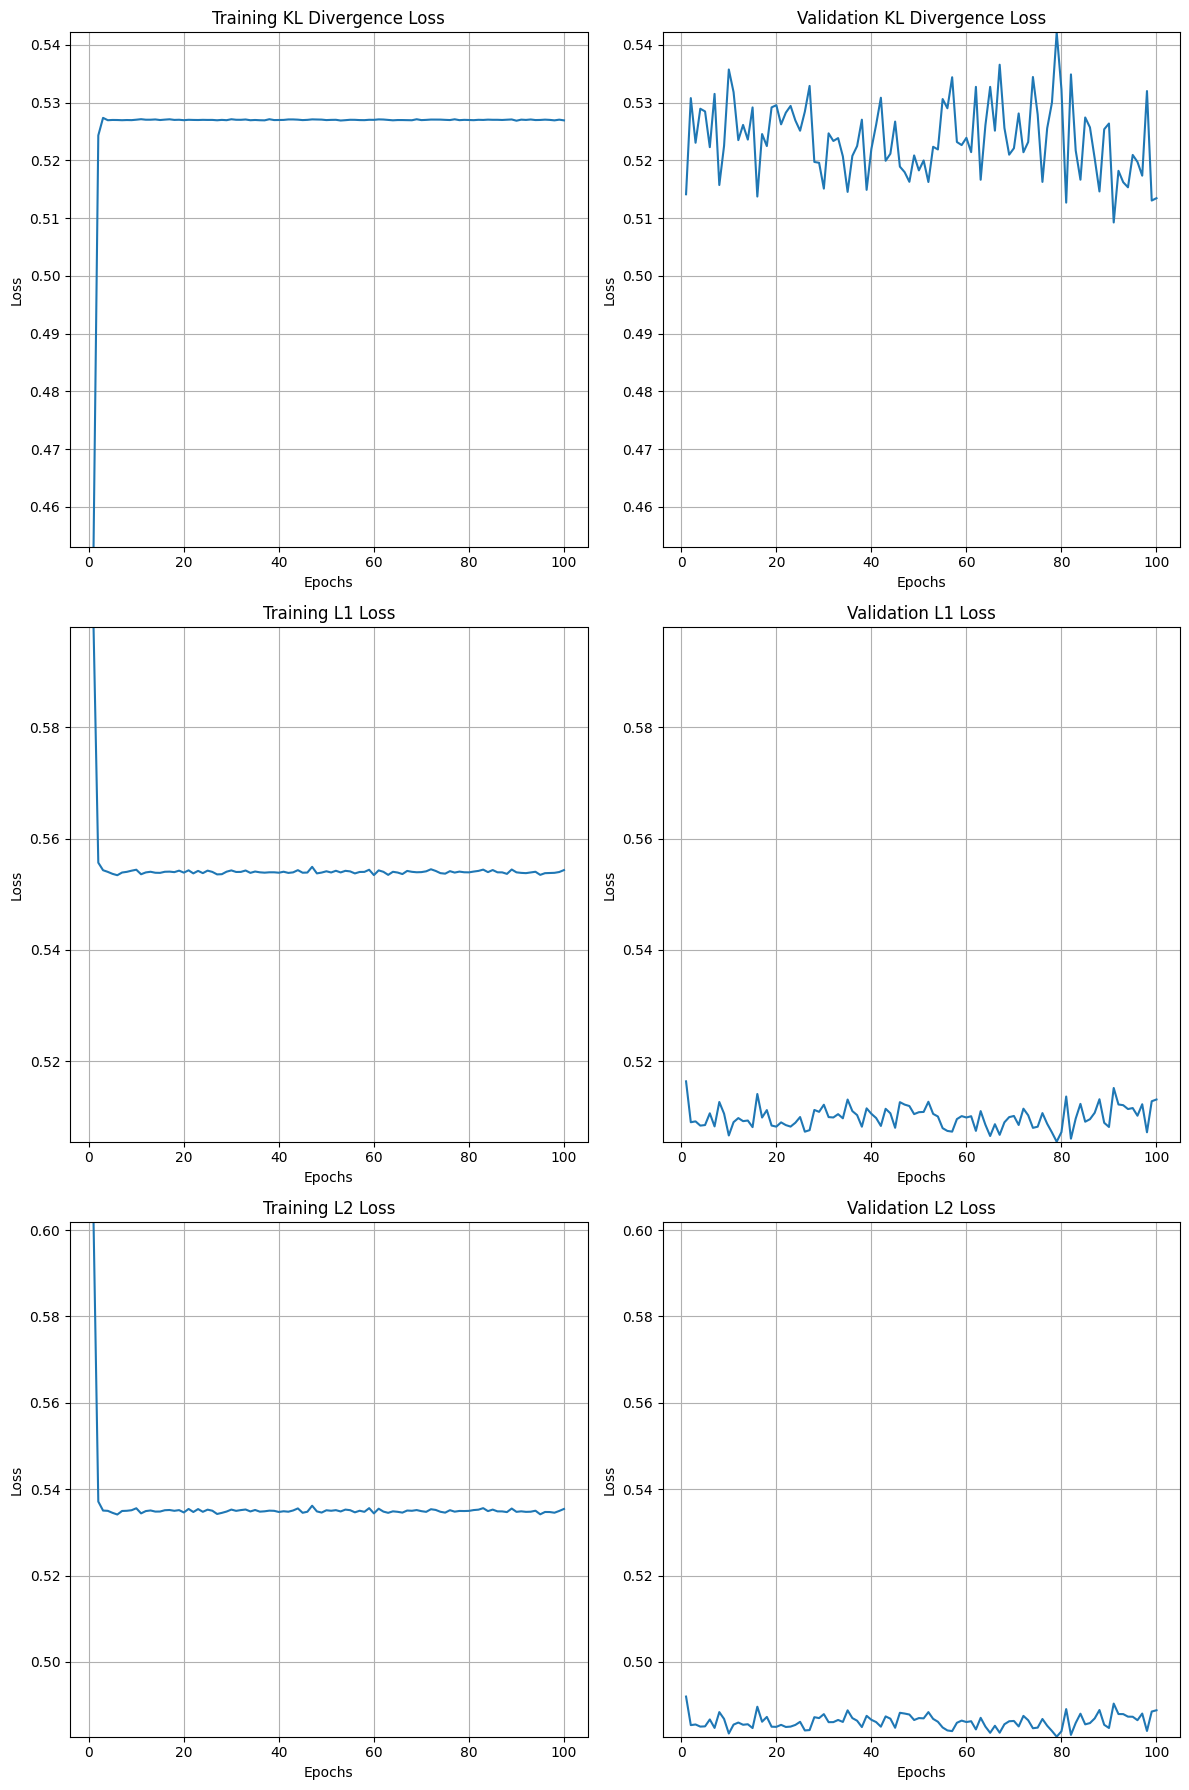

In [13]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [14]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
49.4869 K


In [15]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 8/8 [00:10<00:00,  1.26s/it]


z0: -0.0251
z1: 0.0127
z2: 0.0411
z3: 0.0011


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 754.08it/s]


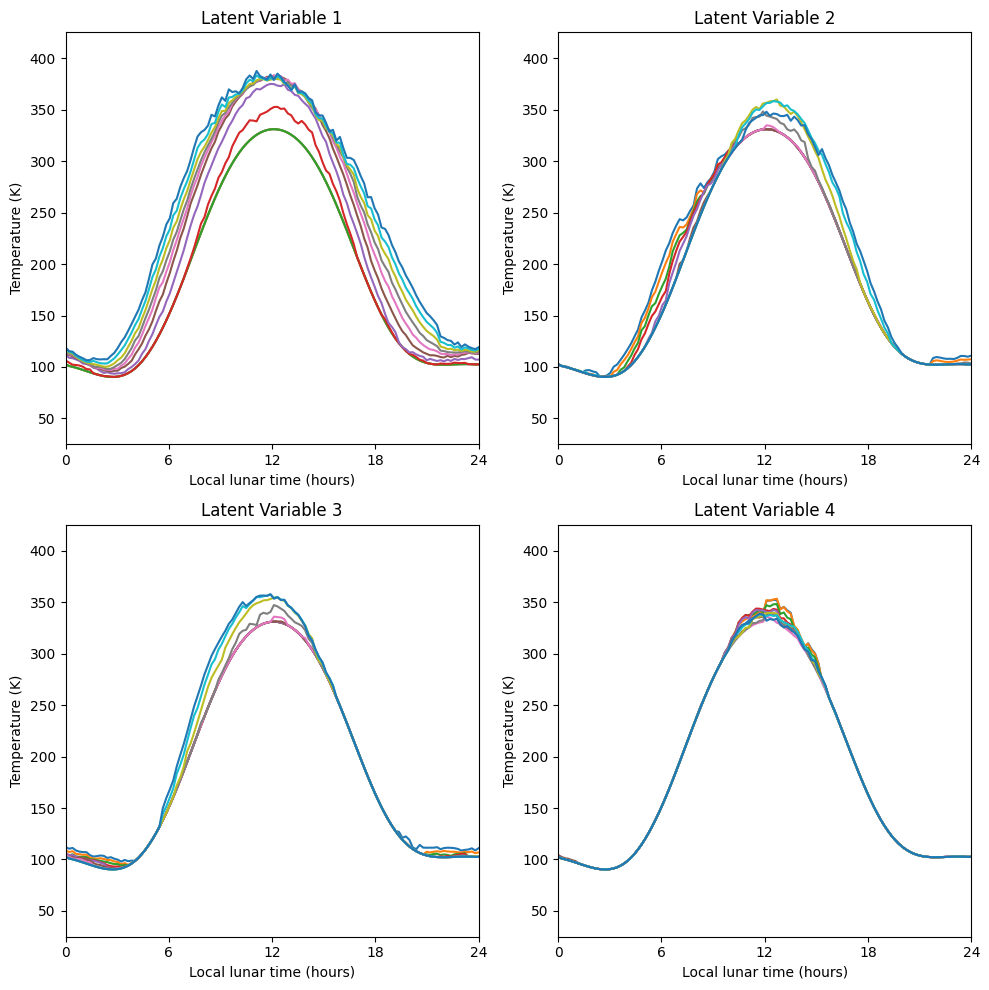

In [16]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)